Generate intial word embedding for headlines and description

The embedding is limited to a fixed vocabulary size (`vocab_size`) but
a vocabulary of all the words that appeared in the data is built.

In [2]:
FN = 'vocabulary-embedding'

In [3]:
seed=42

In [4]:
vocab_size = 40000

In [5]:
embedding_dim = 100

In [6]:
lower = False # dont lower case the text

# read tokenized headlines and descriptions

In [58]:
import pandas

csv_path ='/home/vasudha/Desktop/headlines/newsabc.csv'

training_data = pandas.read_csv(csv_path) 

heads = training_data['Headlines']
desc = training_data['Text']
keywords = []

In [40]:
if lower:
    heads = [h.lower() for h in heads]

In [41]:
if lower:
    desc = [h.lower() for h in desc]

In [42]:
i=0
heads[i]

'Daman & Diu revokes mandatory Rakshabandhan in offices order'

In [43]:
desc[i]

'The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.'

In [45]:
#keywords[i]

In [46]:
len(heads),len(set(heads))

(45140, 4514)

In [47]:
len(desc),len(set(desc))

(45140, 4515)

# build vocabulary

In [48]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return vocab, vocabcount

In [49]:
vocab, vocabcount = get_vocab(heads+desc)

most popular tokens

In [50]:
#print(vocab[:50])
#print(['...'])
# print(len[vocab])

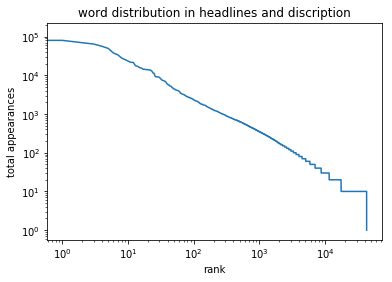

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

always nice to see [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law)

# Index words

In [52]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [53]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

In [54]:
word2idx, idx2word = get_idx(vocab, vocabcount)

# Word Embedding

## read GloVe

In [55]:
fname = 'glove.6B.%dd.txt'%embedding_dim
import os
from keras.utils.data_utils import get_file
datadir_base = os.path.expanduser(os.path.join('~', '.keras'))
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
datadir = os.path.join(datadir_base, 'datasets')
glove_name = os.path.join(datadir, fname)
if not os.path.exists(glove_name):
    path = 'glove.6B.zip'
    path = get_file(path, origin="http://nlp.stanford.edu/data/glove.6B.zip")
    !unzip {datadir}/{path}

unzip:  cannot find or open /home/vasudha/.keras/datasets//home/vasudha/.keras/datasets/glove.6B.zip, /home/vasudha/.keras/datasets//home/vasudha/.keras/datasets/glove.6B.zip.zip or /home/vasudha/.keras/datasets//home/vasudha/.keras/datasets/glove.6B.zip.ZIP.


In [56]:
glove_n_symbols = !wc -l {glove_name}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

ValueError: invalid literal for int() with base 10: 'wc:'

In [57]:
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(glove_name, 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = map(float,l[1:])
        i += 1
glove_embedding_weights *= globale_scale

TypeError: 'SList' object cannot be interpreted as an integer

In [ ]:
glove_embedding_weights.std()

In [ ]:
for w,i in glove_index_dict.iteritems():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

## embedding matrix

use GloVe to initialize embedding matrix

In [ ]:
import numpy as np

# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print 'random-embedding/glove scale', scale, 'std', embedding.std()

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print 'number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size)

lots of word in the full vocabulary (word2idx) are outside `vocab_size`.
Build an alterantive which will map them to their closest match in glove but only if the match
is good enough (cos distance above `glove_thr`)

In [ ]:
glove_thr = 0.5

In [ ]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

for every word outside the embedding matrix find the closest word inside the mebedding matrix.
Use cos distance of GloVe vectors.

Allow for the last `nb_unknown_words` words inside the embedding matrix to be considered to be outside.
Dont accept distances below `glove_thr`

In [ ]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.iteritems():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print '# of glove substitutes found', len(glove_match)

manually check that the worst substitutions we are going to do are good enough

In [ ]:
for orig, sub, score in glove_match[-10:]:
    print score, orig,'=>', idx2word[sub]

build a lookup table of index of outside words to index of inside words

In [ ]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

# Data

In [ ]:
Y = [[word2idx[token] for token in headline.split()] for headline in heads]
len(Y)

In [ ]:
plt.hist(map(len,Y),bins=50);

In [ ]:
X = [[word2idx[token] for token in d.split()] for d in desc]
len(X)

In [ ]:
plt.hist(map(len,X),bins=50);

In [ ]:
import cPickle as pickle
with open('data/%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [ ]:
import cPickle as pickle
with open('data/%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X,Y),fp,-1)